In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
# pip install torch==1.0.0 torchvision==0.2.1 -f https://download.pytorch.org/whl/cu80/torch_stable.html
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu80
# https://download.pytorch.org/whl/cu80/torch-1.0.0-cp35-cp35m-win_amd64.whl
# pip install torch -f https://download.pytorch.org/whl/cu80/torch-1.0.0-cp35-cp35m-win_amd64.whl
# pip install torch -f /d/3.Install/torch-1.0.0-cp37-cp37m-win_amd64.whl (success)
# pip install torch==1.11.0
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# pip install torchsummary
# from torchsummary import summary

In [2]:
# torch.version.cuda
print(torch.version.cuda)

None


### Feature extraction

In [3]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
print(config['data']['frame_size'])

512


In [4]:
fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [5]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS

        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        self.X = np.zeros((20000, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,1))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:] = X_spec[:,n:n+supra_frame_length]
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index] = 0
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:] = X_spec[:,n:n+supra_frame_length]
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index] = 1
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            else:
                ids_train.append(i)
        return (ids_train, ids_test)

label =  1.0


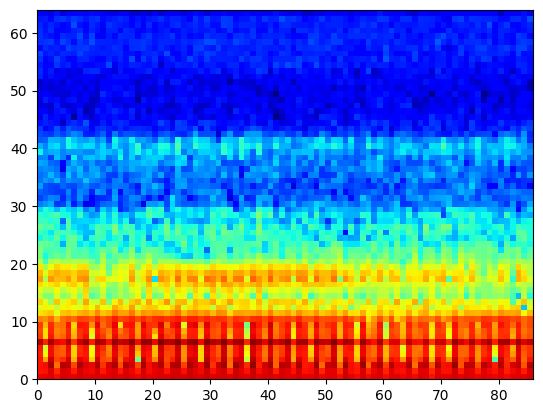

In [8]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(12200)

plt.pcolor(X_generic, cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_test = DataSet_ALS.get_kth_fold_inds(4)

### NN-model

In [6]:
class ALS_FFNN(nn.Module):
    def __init__(self):
        super(ALS_FFNN,self).__init__() 
        # parameters
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        self.frames_in_segment = config['data']['supra_frame_length']
        self.fc = nn.Linear(self.n_mel*self.frames_in_segment,1)
        nn.init.xavier_uniform_(self.fc.weight, gain=1.0)
    
    def forward(self, x):
        out = x.view(-1,self.n_mel*self.frames_in_segment)
        out = self.fc(out)
        return out    

In [31]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):    
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        # iter = 1
        for specs, labels in train_loader:
            specs = specs.float()
            outputs = model(specs)
            outputs = outputs.squeeze()            
            # print(outputs)
            # print(labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            # if iter%500==0:
            #     print(f'{datetime.datetime.now()} Iter {iter}')
            # iter=iter + 1

        if epoch==1 or epoch%5==0:
            print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}')

### Single NN training & evaluation

In [16]:
fold_0_train_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1

ALS_ffnn = ALS_FFNN()
ALS_ffnn.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(ALS_ffnn.parameters(),lr=1e-4)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    model=ALS_ffnn,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-05-12 15:15:24.001654 Epoch 1, Train loss 2.404245296802819
2023-05-12 15:15:24.869958 Epoch 2, Train loss 0.874554066349372
2023-05-12 15:15:25.746050 Epoch 3, Train loss 0.7885269097557132
2023-05-12 15:15:26.660760 Epoch 4, Train loss 0.619294850156132
2023-05-12 15:15:27.518776 Epoch 5, Train loss 0.682615871143993
2023-05-12 15:15:28.331202 Epoch 6, Train loss 0.7157369371866507
2023-05-12 15:15:29.224169 Epoch 7, Train loss 0.5242129157860714
2023-05-12 15:15:30.118992 Epoch 8, Train loss 0.5832486762961843
2023-05-12 15:15:31.008834 Epoch 9, Train loss 0.4268240641629844
2023-05-12 15:15:31.876173 Epoch 10, Train loss 0.5139924594485441
2023-05-12 15:15:32.727874 Epoch 11, Train loss 0.3902339525334822
2023-05-12 15:15:33.650718 Epoch 12, Train loss 0.364496729557785
2023-05-12 15:15:34.526573 Epoch 13, Train loss 0.3788443533240386
2023-05-12 15:15:35.397061 Epoch 14, Train loss 0.323219198668103
2023-05-12 15:15:36.254113 Epoch 15, Train loss 0.36431203435413567
2023-05-1

In [ ]:
ALS_ffnn.eval()

test_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_test_inds)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False) # num_workers=1

test_score = list()
TP_TN_sum = 0
with torch.no_grad():
    for spec, label in test_loader:
        spec = spec.float()
        spec = spec.squeeze()
        pred = ALS_ffnn(spec)
        test_score.append(pred.numpy())
        if pred>0:
            pred = torch.tensor(1, dtype=torch.float64)
        else:
            pred = torch.tensor(0, dtype=torch.float64)
            # print('Neg example')    
        if pred==label:
            TP_TN_sum +=1

print('Acc = ', TP_TN_sum/len(test_score))

test_score = np.array(test_score).squeeze()
plt.plot(test_score)

### Train with 5-fold CV

In [32]:
def crossvalid(dataset=None, model = None, train = None, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)

    for i in range(k_fold):
        
        inds_train,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True)  # num_workers=2
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                          shuffle=False)    # num_workers=2
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
        
        model.train()

        # optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
        optimizer = optim.Adam(model.parameters(),lr=5e-4, weight_decay=1e-2) # weight_decay is L2 regularization

        loss_fn = nn.BCEWithLogitsLoss()

        train(
            n_epochs=50,
            optimizer=optimizer,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                spec = spec.squeeze()
                pred = model(spec)
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

In [33]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
ALS_ffnn = ALS_FFNN()

crossvalid(dataset=DataSet_ALS, model = ALS_ffnn, train = training_loop, k_fold=5)

2023-05-13 12:12:23.155185 Epoch 1, Train loss 3.574
2023-05-13 12:12:27.314498 Epoch 5, Train loss 0.645
2023-05-13 12:12:32.305342 Epoch 10, Train loss 0.810
2023-05-13 12:12:37.724892 Epoch 15, Train loss 0.708
2023-05-13 12:12:42.797704 Epoch 20, Train loss 0.942
2023-05-13 12:12:47.740016 Epoch 25, Train loss 0.412
2023-05-13 12:12:52.494294 Epoch 30, Train loss 0.779
2023-05-13 12:12:57.187033 Epoch 35, Train loss 0.408
2023-05-13 12:13:01.865170 Epoch 40, Train loss 0.420
2023-05-13 12:13:06.491515 Epoch 45, Train loss 0.543
2023-05-13 12:13:11.205266 Epoch 50, Train loss 0.766
Acc =  0.7938988095238095
2023-05-13 12:13:13.137204 Epoch 1, Train loss 1.837
2023-05-13 12:13:16.923475 Epoch 5, Train loss 0.591
2023-05-13 12:13:21.768620 Epoch 10, Train loss 0.293
2023-05-13 12:13:26.568516 Epoch 15, Train loss 0.991
2023-05-13 12:13:31.816928 Epoch 20, Train loss 0.702
2023-05-13 12:13:36.808286 Epoch 25, Train loss 0.159
2023-05-13 12:13:42.485330 Epoch 30, Train loss 0.267
2023-0

0.6491889234802556

In [18]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))


torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
